## **DSCI 100 Project Report: Using Age and Playtime to Predict Game-Related Newsletter Subscriptions among Minecraft Players**

Ayra Layug (95650768), Claire Hsu (79515375), Prabhnoor Karwal(30623383)

### **Introduction**

Computer Science researchers at the University of British Columbia are currently developing embodied AI agents capable of mimicking human-like interactions and responses (Pacific Laboratory for Artificial Intelligence, n.d.). Embodied AI is a subfield of artificial intelligence that can interact and learn from their physical or virtual environments through the inputs and actions of others, such as humans. However, to develop such dynamic agents, a performance benchmark must first be established to effectively evaluate if the capabilities of these AI agents align with real human cognition and physical behaviours.  

To achieve this, the researchers launched a public multiplayer Minecraft server, where participants were encouraged to engage with the world and their fellow players. These interactions were then recorded and analyzed to gain an understanding of natural human speech and perception, ultimately helping to define that quantitative metric. 

However, this would require extensive gameplay and a substantial number of participants to fully optimize this metric. Therefore, it is crucial to identify the underlying patterns and relationships among participants to better allocate resources and support the number of players, which ensures the success of the study. 

The `players` data set contains participant data with the following 7 columns, each with 196 observations: 

**Categorical**
- `experience` – video game skill level  
- `gender` - gender of participants
- `name` – name of participant
- `hashed email` – encrypted email for participant privacy
- `subscribe` – subscription to game-related newsletters (`TRUE` or `FALSE`)

**Numerical**
- `played_hours` - number of hours spent playing video games (ie. Minecraft)
- `age` - age of participants

As all individuals are unique and diverse from each other, it can be inferred that variability will exist across the observations for each variable. Therefore, this report aims to address the broad question: What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types? Specifically, can age and playtime predict the likelihood of individuals subscribing to game-related newsletters? This can provide researchers valuable information on how to tailor their advertising efforts via newsletter content to better attract their desired player demographic and increase participation. 

### **Methods & Results**

The following steps were completed to answer our specific question:
1. **Load Relevant Libraries** 
2. **Loading Data**: Reading in `players.csv`
3. **Wrangle/Clean**: Isolate desired variables and impute any missing values.
4. **Summary Statistics**: Compute relevant means and proportion of subscriptions. 
5. **Visualizations**: Plot playtime and age vs. subscription to determine which group have the largest proportion for subscribing, and playtime vs. age to discern the distribution across individuals.
7. **Prediction analysis**: As we want to predict a categorical variable/class, KNN classification will be used to predict `subscribe` with `played_hours` and `Age` as predictors.
8. **Results of KNN model**: Tunning KNN with best K; Calculating accuracy, precision, recall, and confusion matrix to assess the KNN model. 

In [26]:
#setting the seed
set.seed(1324)

# Load libraries
library(tidyverse)
library(tidymodels)
library(themis)

# 1. Load data
players_url <- "https://raw.githubusercontent.com/prabhnoor-k/DSCI-100-Project/refs/heads/main/players.csv"
unwrangled_players <- read.csv(players_url)

head(unwrangled_players)

,experience,subscribe,hashedEmail,played_hours,name,gender,Age
,<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<int>
1,Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
2,Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
3,Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
4,Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
5,Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
6,Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


In [27]:

# 2. Wrangle and clean; isolate for desired variables
players <- unwrangled_players |>
    select(subscribe, played_hours, Age) |>
    mutate(
        subscribe = as.factor(subscribe)  # Convert logical to factor for classification
  )

players_recipe <- recipe(~ ., data = players) |>
  step_impute_mean(Age) |>   # impute missing age values 
  prep()

players <- bake(players_recipe, new_data = players)

#Display first couple of rows to ensure desired columns were isolated  
head(players)

subscribe,played_hours,Age
<fct>,<dbl>,<int>
TRUE,30.3,9
TRUE,3.8,17
FALSE,0.0,17
TRUE,0.7,21
TRUE,0.1,21
TRUE,0.0,17


In [28]:
# Splitting the Data into Training and Testing Sets. Use Training Set for Exploratory Data Analysis

split <- initial_split(players, prop = 0.75, strata = subscribe)
players_train <- training(split)
players_test <- testing(split)

glimpse(players_train) #used to view data properly

Rows: 147
Columns: 3
$ subscribe    <fct> FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, F…
$ played_hours <dbl> 0.0, 0.0, 0.1, 0.0, 0.1, 0.0, 0.0, 0.9, 0.2, 0.0, 0.0, 0.…
$ Age          <int> 21, 22, 17, 23, 18, 24, 23, 18, 37, 23, 17, 18, 17, 26, 2…


In [47]:
# 3. Summary Statistics

summary_table <- players_train |>
    summarise(
        Mean_Played_Hours_for_all = mean(played_hours),
        Mean_Age_for_all = mean(Age),
        Mean_prop_Subscribed = mean(as.numeric(subscribe) - 1))

# display summary statistics
summary_table

Mean_Played_Hours_for_all,Mean_Age_for_all,Mean_prop_Subscribed
<dbl>,<dbl>,<dbl>
5.070068,20.39456,0.7346939


These summary statistics suggest that the average age of players is early 20s, and playtime is approximately 5 hours. Furthermore, a large proportion of players *are* subscribing to game-related newsletters. 

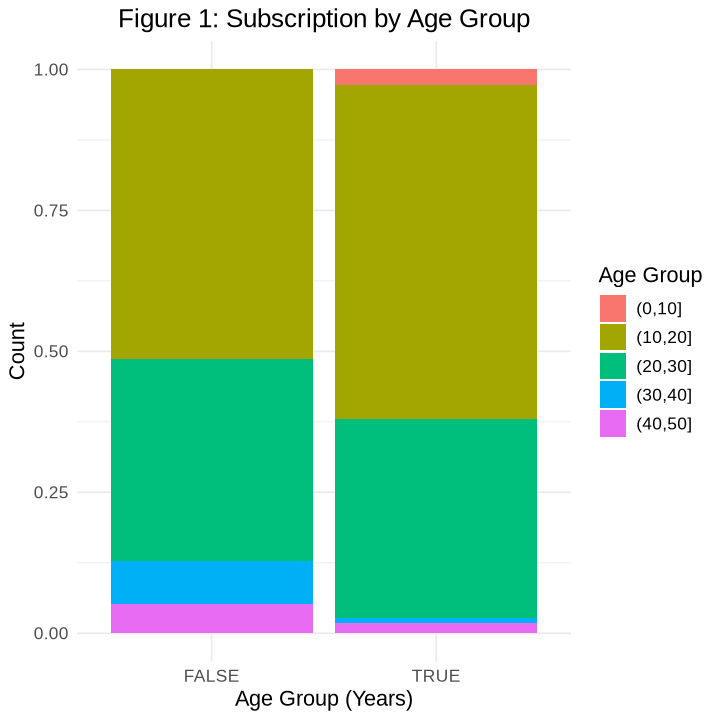

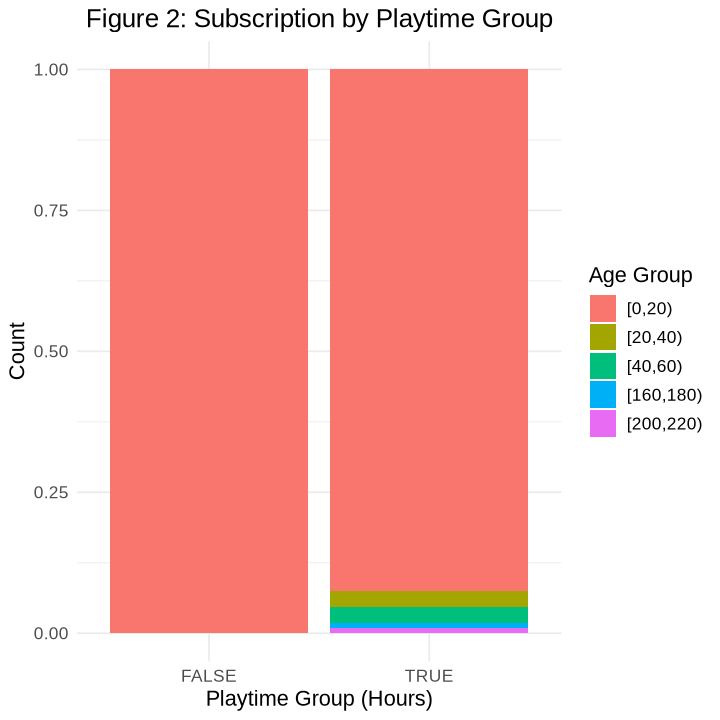

In [30]:
# 4. Visualization 

options(repr.plot.width = 6, repr.plot.height = 6)

# Figure 1: Bar plot of Subscription by Age Group vs. Subscription 
age_bins <- players_train |>
    mutate(Age_Group = cut(Age, breaks = seq(0, 50, by = 10))) 

fig1 <- ggplot(age_bins, aes(x = subscribe, fill = Age_Group)) +
    geom_bar(position = "fill") +
    labs(x = "Age Group (Years)", y = "Count", 
        title = "Figure 1: Subscription by Age Group", fill = "Age Group") +
    theme_minimal() +
    theme(text = element_text(size = 13),
          plot.title = element_text(hjust = 0.5))

fig1

# Figure 2: Bar plot of Playtime vs. Subscription
playtime_bins <- players_train |>
      mutate(Playtime_Group = cut(played_hours, breaks = seq(0, 240, by = 20), right = FALSE)) 

fig2 <- ggplot(playtime_bins, aes(x = subscribe, fill = Playtime_Group)) +
    geom_bar(position = "fill") +
    labs(x = "Playtime Group (Hours)", y = "Count", 
        title = "Figure 2: Subscription by Playtime Group", fill = "Age Group") +
    theme_minimal() +
    theme(text = element_text(size = 13),
          plot.title = element_text(hjust = 0.5))

fig2

Figure 1: Subscription by Age Group shows how individuals aged 10 to 30 years old comprise the largest proportion of subscribers to game-related newsletters. Similarly, when one plots subscription against playtime by age group, the graph reveals that younger players (0, 20) have the largest proportion of played hours and are more likely to subscribe, which supports the findings of Figure 1 and the summary statistics of the means.

Consequently, this indicates a potential relationship between age and playtime and their role as key predictors for determining the likelihood of an individual subscribing to game-related newsletters.

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”


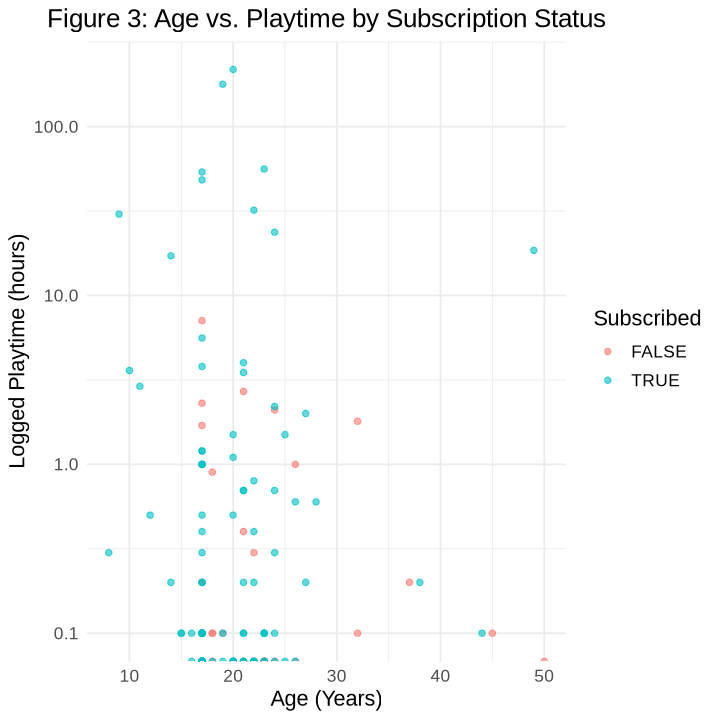

In [31]:

options(repr.plot.width = 6, repr.plot.height = 6)

# Figure 3: Scatterplot of Age vs. Playtime by Subscription
    fig3 <- ggplot(players_train, aes(x = Age, y = played_hours, color = subscribe)) +
    geom_point(alpha = 0.6) +
    labs(x = "Age (Years)", y = "Logged Playtime (hours)", 
    title = "Figure 3: Age vs. Playtime by Subscription Status", color = "Subscribed") +
    scale_y_log10()+  #logged playtime to better visualize the trend 
    theme_minimal() +
    theme(text = element_text(size = 13),
          plot.title = element_text(hjust = 0.5))

fig3

Additionally, a scatterplot was generated to show each individual's exact age, logged-transformed playtime, and subscription status. This illustrates that most players fall between ages 15-25, and those with higher playtimes generally tend to be subscribers. In contrast, individuals who are 30+ tend to play significantly less and are less likely to subscribe to these game-related newsletters. 

As such, this supports the observed results produced by the bar plots and provides insight into how the data is distributed and varies across age groups. 

In [48]:
# 5. Data Analysis with KNN

# Model Specification for Tuning Model 
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_mode("classification") |>
            set_engine("kknn")

# Tibble for all k values
k_vals <- tibble(neighbors = seq(from = 1, to = 40, by = 1))

# Recipe with standardization
recipe <- recipe(subscribe ~ played_hours + Age, data = players_train) |>
  step_scale(all_predictors()) |>  
  step_center(all_predictors()) |>
  step_upsample(subscribe) # upsampling because there are too many TRUE values (ie. oversampling the rarer FALSE class)

# Cross validation
data_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)

# Fitting data and collecting Metrics
knn_metrics <- workflow() |>
  add_recipe(recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = data_vfold, grid = k_vals) |>
  collect_metrics()

k_accuracies <- knn_metrics |> filter(.metric== "accuracy")
k_accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.4606240,5,0.03979086,Preprocessor1_Model01
2,accuracy,binary,0.4541872,5,0.03127934,Preprocessor1_Model02
3,accuracy,binary,0.4272906,5,0.05994757,Preprocessor1_Model03
4,accuracy,binary,0.4344335,5,0.05825980,Preprocessor1_Model04
5,accuracy,binary,0.4955993,5,0.05097506,Preprocessor1_Model05
6,accuracy,binary,0.4955993,5,0.05097506,Preprocessor1_Model06
7,accuracy,binary,0.4617898,5,0.04347994,Preprocessor1_Model07
8,accuracy,binary,0.4617898,5,0.04347994,Preprocessor1_Model08
9,accuracy,binary,0.4541708,5,0.05503286,Preprocessor1_Model09


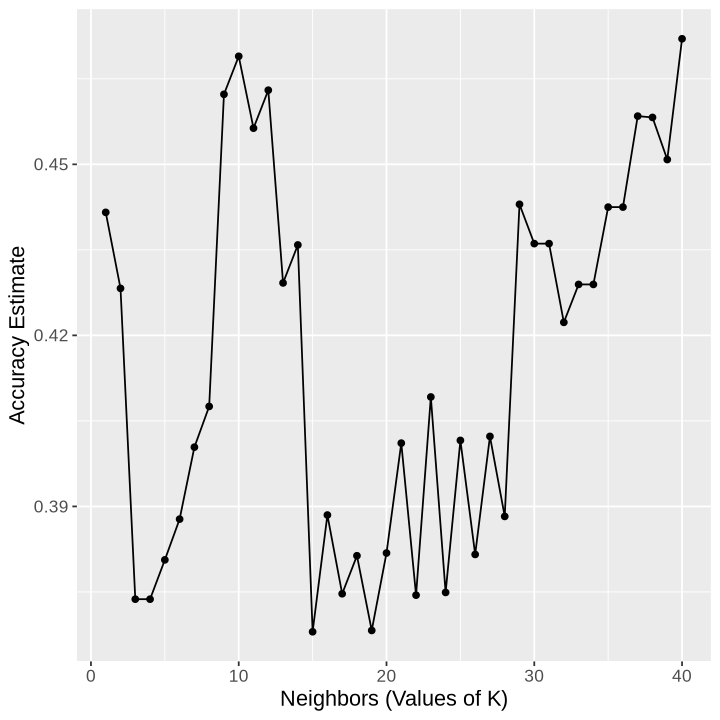

In [41]:
# Plotting graph for accuracy versus values of K 

acc_graph <- ggplot(k_accuracies , aes(x= neighbors, y= mean)) +
                    geom_point()+
                    geom_line()+
                    labs(x= "Neighbors (Values of K)", y= "Accuracy Estimate") +
                    theme(text= element_text(size = 13))
acc_graph

According to the graph, we see that the best value of K occurs arround 40 with the highest accuracy estimate, now we find that: 

In [34]:
# Finding best k
best_k <- k_accuracies |> 
    arrange(desc(mean)) |> 
    head(1) |> 
    pull(neighbors)

best_k

[1] 40

In [35]:
# Using the Best K to predict

new_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
            set_mode("classification") |>
            set_engine("kknn")

# using old recipe from model tuning 

new_fit <- workflow() |>
        add_recipe(recipe) |>
        add_model(new_spec) |>
        fit(data = players_train)

new_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
3 Recipe Steps

• step_scale()
• step_center()
• step_upsample()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(40,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3935185
Best kernel: rectangular
Best k: 40

In [36]:
#Using testing data to assess model 

players_predictions <- predict(new_fit, players_test) |> bind_cols(players_test)
players_predictions |> metrics(truth= subscribe, estimate = .pred_class) |>
                       filter(.metric == "accuracy")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.4897959


In [40]:
#Determing label order for "true positive". Here, this is "TRUE" 
label_order <- players_predictions |> pull(subscribe) |> levels()

#Calculating precision, recall, and confusion matrix 
precision <- players_predictions |> 
                precision(truth = subscribe,
                          estimate = .pred_class, event_level = "second")

precision

recall <- players_predictions |> 
            recall(truth = subscribe,
                   estimate = .pred_class, event_level = "second")
                                            
recall

confusion_matrix <- players_predictions |> 
                    conf_mat(truth = subscribe, 
                             estimate = .pred_class)
confusion_matrix 

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.8666667


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.3611111


          Truth
Prediction FALSE TRUE
     FALSE    11   23
     TRUE      2   13

The current model has an accuracy of 49%, indicating that it correctly predicts whether an individual will be a subscriber or not (based on age and played hours) about ~50% of the time. Furthermore, from the confusion matrix, the model predicted 23 false negatives and 13 true positives. In comparison, it correctly predicted 11 true negatives and only 2 false negatives. Therefore, the model is underpredicting the TRUE class. 

Additionally, the model has a calculated precision of 87% and a low recall of 36%. This suggests the model is highly selective in identifying true positive cases only when it is completely confident. As a result, it missed many true positives where the individual was a subscriber, as seen from the confusion matrix.

### Discussion

Following the data analysis using K-nearest neighbours (KNN) classification, the model has an accuracy of 49%, signifying that it correctly predicts whether individuals are true subscribers about 50% of the time. This relatively low accuracy may be attributable to how KNN inherently works as an algorithm. In KNN, each data point is given a singular vote with equal power (defined during the model specifications) when classifying new observations. Therefore, the model is sensitive to imbalances. 

Based on the initial exploratory analyses, Figures 1 and 2 show that most subscribers to game-related newsletters are aged 10 to 30 and tend to exhibit the highest playtime among the study participants. However, this age range also comprises those least likely to subscribe. As a result, the model has difficulty distinguishing between true positives and false negatives. This is corroborated by Figure 3, which illustrates how subscribers and non-subscribers overlap in the key predictor variables (age and playtime) in the mid-teens to late-20s age range. Furthermore, this lack of clear distinction likely contributes to the model's conservativeness in identifying true positives unless it is completely confident, and its low recall of failing to capture many true positives. Consequently, the model struggles to have definitive predictions for subscription status. 

These results were somewhat unexpected. Given our exploratory graphs, we anticipated a stronger relationship between the predictor variables and the categorical response variable because of the distinct trend shown in Figure 3, which plots logged playtime vs. age. As mentioned, one can clearly observe that participants around age 20 tend to have greater playtimes and are mostly subscribers, suggesting they could be suitable predictors. However, we seemingly overlooked if the inverse trend was possible as well.  


Due to the low accuracy of our final model, it is not ideal for elucidating relationships between player characteristics or recruitment efforts in the PLAICraft study. To improve the model's accuracy, one can incorporate more relevant predictor variables during the model specifications to provide our KNN with additional information to better group similar and close data points together in the feature space. As such, this may lead to exploring other key characteristics, such as gender and experience level, and their effects on player variation. This adds complexity to the performance benchmark of PLAICraft's embodied AI, ultimately improving the training process for these agents to react and respond as human-like as possible during gameplay. 

### References 

Pacific Laboratory for Artificial Intelligence (PLAI). (n.d.) *PLAICraft*. University of British Columbia.. https://plai.cs.ubc.ca/research/minecraft-meets-ai-research-with-plai/ 